In [1]:

%pprint

Pretty printing has been turned OFF



## Plot Coherence by Topic Model Parameters

In [2]:

%%time
%run ../py/html_analysis.py

lda = LdaUtilities(verbose=True)

Wall time: 26.8 s


In [3]:

# Get ratio of headers to non-headers
import numpy as np

sql_str = '''
    SELECT COUNT(np.[navigable_parent]) AS header_count
    FROM [Jobhunting].[dbo].[NavigableParents] np
    WHERE np.[is_header] = 1'''
is_header_df = pd.DataFrame(lda.su.get_execution_results(lda.cursor, sql_str))
header_count = is_header_df.header_count.squeeze()
sql_str = '''
    SELECT COUNT(np.[navigable_parent]) AS nonheader_count
    FROM [Jobhunting].[dbo].[NavigableParents] np
    WHERE np.[is_header] = 0'''
is_nonheader_df = pd.DataFrame(lda.su.get_execution_results(lda.cursor, sql_str))
nonheader_count = is_nonheader_df.nonheader_count.squeeze()
nonheader_fraction = nonheader_count/(header_count + nonheader_count)
header_fraction = header_count/(header_count + nonheader_count)
alpha = np.array([nonheader_fraction, header_fraction], dtype=np.float32)
extra_params_list = [('chunksize', 50), ('passes', 75), ('alpha', alpha), ('decay', 0.6),
                     ('iterations', 29), ('gamma_threshold', 1e-10), ('minimum_probability', 0.001)]

In [4]:

from time import time
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import itertools

# Compute Coherence Scores
id2word = {v: k for k, v in lda.LDA_DICTIONARY.token2id.items()}
y = []
x = []
t = []
for i, extra_params_tuple_list in enumerate(itertools.combinations(extra_params_list, 2)):
    extra_params_dict = {}
    for extra_params_tuple in extra_params_tuple_list:
        param = extra_params_tuple[0]
        value = extra_params_tuple[1]
        extra_params_dict[param] = value
    x.append(i)
    t0 = time()
    lda.TOPIC_MODEL = LdaModel(corpus=lda.LDA_CORPUS, num_topics=2, id2word=id2word, **extra_params_dict)
    y.append(CoherenceModel(model=lda.TOPIC_MODEL, texts=lda.tokenized_sents_list, corpus=lda.LDA_CORPUS,
                            dictionary=lda.LDA_DICTIONARY).get_coherence())
    t.append(time() - t0)

In [5]:

sorted([(tn, cv) for tn, cv in zip(x, y)], key=lambda x: x[1], reverse=True)

[(1, 0.686664564296938), (4, 0.6828974772447973), (18, 0.6488302698430759), (8, 0.5826933025864333), (10, 0.5801802934683804), (13, 0.5798959680131703), (9, 0.5759609871763032), (6, 0.5750685786268215), (15, 0.5683090690571928), (11, 0.5645689759605741), (17, 0.5551757485585194), (7, 0.5326412322064963), (20, 0.5260176630470664), (12, 0.5210784571252395), (16, 0.517793111401665), (3, 0.49668829304610307), (19, 0.479502674720919), (14, 0.4787832754721244), (2, 0.47042161172210256), (0, 0.43363160389809596), (5, 0.43002842620093984)]

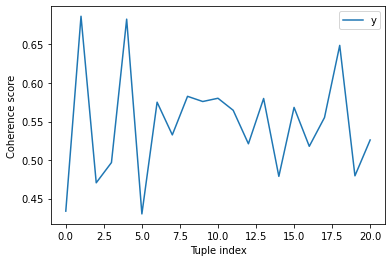

In [6]:

# Show graph
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.xlabel('Tuple index')
plt.ylabel('Coherence score')
plt.legend(('y'), loc='best')
plt.show()

In [9]:

sorted([(tn, cv) for tn, cv in zip(x, t)], key=lambda x: x[1], reverse=False)

[(2, 99.03012919425964), (12, 114.29960989952087), (14, 115.87537908554077), (3, 122.86201977729797), (11, 124.91074013710022), (17, 125.20385336875916), (15, 125.91591286659241), (1, 126.44832038879395), (13, 128.04866361618042), (5, 128.26471877098083), (18, 133.62424683570862), (19, 135.1708700656891), (4, 139.60304760932922), (16, 144.86652851104736), (20, 145.2826428413391), (6, 763.8294193744659), (10, 784.9141943454742), (7, 814.3604853153229), (8, 822.0041518211365), (0, 855.5833640098572), (9, 1667.151938676834)]

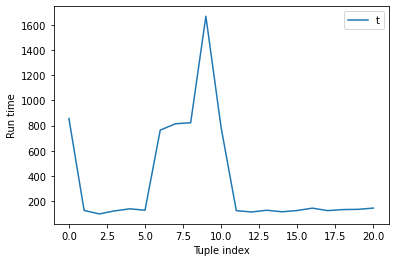

In [7]:

# Show time graph
plt.plot(x, t)
plt.xlabel('Tuple index')
plt.ylabel('Run time')
plt.legend(('t'), loc='best')
plt.show()

In [14]:

sorted([(tn, cv) for tn, cv in zip(y, t)], key=lambda x: x[0], reverse=True)

[(0.686664564296938, 126.44832038879395), (0.6828974772447973, 139.60304760932922), (0.6488302698430759, 133.62424683570862), (0.5826933025864333, 822.0041518211365), (0.5801802934683804, 784.9141943454742), (0.5798959680131703, 128.04866361618042), (0.5759609871763032, 1667.151938676834), (0.5750685786268215, 763.8294193744659), (0.5683090690571928, 125.91591286659241), (0.5645689759605741, 124.91074013710022), (0.5551757485585194, 125.20385336875916), (0.5326412322064963, 814.3604853153229), (0.5260176630470664, 145.2826428413391), (0.5210784571252395, 114.29960989952087), (0.517793111401665, 144.86652851104736), (0.49668829304610307, 122.86201977729797), (0.479502674720919, 135.1708700656891), (0.4787832754721244, 115.87537908554077), (0.47042161172210256, 99.03012919425964), (0.43363160389809596, 855.5833640098572), (0.43002842620093984, 128.26471877098083)]

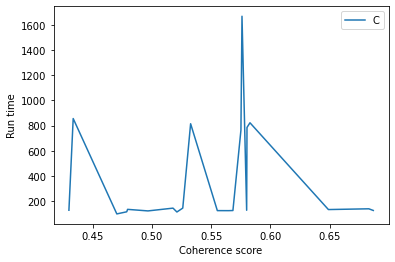

In [17]:

# Show time graph
tuple_list = sorted([(tn, cv) for tn, cv in zip(y, t)], key=lambda x: x[0], reverse=True)
coherence_score = [x[0] for x in tuple_list]
run_time = [x[1] for x in tuple_list]
plt.plot(coherence_score, run_time)
plt.ylabel('Run time')
plt.xlabel('Coherence score')
plt.legend(('Coherence score'), loc='best')
plt.show()

In [18]:

list(itertools.combinations(extra_params_list, 2))[1]

(('chunksize', 50), ('alpha', array([0.87972766, 0.12027232], dtype=float32)))